# Intro to language modeling

## Recap
- in the last notebook we took an into to language modeling
- we also built a bigram language model using the counts approach (intuitive approach) and also using the neural network approach (a single layer neural network)
- we said the neural approach is better and more scalable as we can complexify the network to learn more complex patterns
- we said the probme with bigram is that it only looks at a small context window (2 characters)

- we will build a lot of architectures of character-level language models
    - ✔ Bi-gram (one character simply predicts a next one with a lookup table of counts)
    - MLP (Multi-Layer Perceptron), following [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Bengio et al. 2003
    - RNNs (Recurrent Neural Networks), following [Recurrent Neural Network Based Language Model](https://www.fit.vut.cz/research/group/speech/public/publi/2010/mikolov_interspeech2010_IS100722.pdf), Mikolov et al. 2010
    - GRUs (Gated Recurrent Units), following [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259), Cho et al. 2014
    - Transformers (the Equivalent of GPT-2), following [Attention is All You Need](https://arxiv.org/abs/1706.03762), Vaswani et al. 2017

## MLP (Multi-Layer Perceptron)

- the paper by Bengio et al. 2003 used a vocabulary of 17000 words (so it was a word-level language model), but we will use a character-level language model
- They proposed to take every token (word) and associate it with say a 30-dimensional feature vector (embedding)
    - so every token is now embedded into a 30-dimensional space
    - so, they have 17000 points (vector) in that 30-dimensional space (you might imagine that is very crowded, that is a lot of points for a very small space)
    - now, these points (vectors) are initialized completely randomly, then we are going to tune these embeddings of these words using backpropagation
    - so during the course of training of this neural network, these points (vectors) are going to move around in this 30-dimensional space
        - and we might imagine that words that have very similar meanings (or indeed synonyms of each other) might end up in a very similar part of this space (mine: because they are used in similar contexts and will have similar updates)
        - conversely, words that have very different meanings would go somewhere else in this space

- otherwise, everything else is identical to what we have been doing
    - they are predicting the next token given the previous tokens
    - to train the network, they are maximizing the log likelihood of the training data (or minimizing the average negative log likelihood), which corresponds to maximizing the probability of the actual next token given the previous tokens

- why does it work?
    - it works because of the embeddings (feature vectors), since similar words will be in similar context or used interchangeably, they will have updates
        - so, that way they will have similar embeddings (features), and this allows the model to generalize to new phrases that are combinations of words that it has seen before
            - suppose that the model was train on the phrase `The dog was running in the room`, and it learned that the words `The` and `a` are used in similar contexts and used interchangeably, therefore they have similar embeddings
            - so during test time, if the model sees the phrase `A dog was running in the ...`, to the model `a` and `The` are very similar, they have similar features (embeddings), so it is almost like it has seen that phrase before (it's almost like we are feeding it a sentence it has been trained on), and will be able to predict the next  `room` correctly as a result
            - similarly, it can learn that `dog` and `cat` are similar as they are both animals, walking, running are both similar, etc.  


- The diagram of the architecture they used

![mlp](assets/mlp.png)


- they are taking 3 previous tokens (words) and predicting the 4th token (word) in the sequence
- as they had a vocabulary of 17000 words, so every one of the 3 inputs is the index of the word in the vocabulary (from 0 to 16999)
- there is also a lookup table (they call it Matrix C), which is a 17000 x 30 matrix
    - so, every index will bluck out a row of that matrix (which is a 30-dimensional vector)
    - that way we can map each index (of the word) to a 30-dimensional embedding vector for that word
- now we have 3 30-dimensional vectors (embeddings) for the tokens (words), making up the input layer of the neural network (90 neurons in total)
- the hidden layer has a size which is a hyperparameter, and has a `tanh` activation function
    - we use the word `hyperparameter` when it's kind of a design choice that we make up to us (it can be as large or as small as we want)
    - and we are going to go over multiple choices of this hyperparameter and evaluate how well each of them does
- then we have an output layer, and sinc there are 17000 tokens -words- that could come next, we have 17000 neurons in the output layer (each is indicating the probability of the next token being that word)
    - and it has a softmax activation function (to convert the logits into probabilities)

- architecture summary:
    - inputs: 3 words (indices of the words in the vocabulary)
    - Matrix C: 17000 x 30 matrix (lookup table), mapping each index to a 30-dimensional embedding vector
    - input layer: 90 neurons (3 x 30-dimensional embeddings)
    - hidden layer: size is a hyperparameter, with `tanh` activation function
    - output layer: 17000 neurons, with `softmax` activation function



- the training is the same, we will use the index of the next actual token to index into the output layer of the model and get the corresponding probability of that token, and we will maximize that probability (or more precisely minimize the negative log of that probability which is equivalent)
    - in other words, update the weights of the model to make the probability of the actual next token as high as possible

- Tip: there are dashed lines in the diagram, they represent variations in the architecture that we will not explore

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
words = open('makemore/names.txt').read().splitlines()

In [5]:
len(words)

32033

## Build the Vocabulary

In [6]:
# build the vocabulary
vocab = sorted(list(set(''.join(words))))
stoi = { ch: i+1 for i, ch in enumerate(vocab) }
stoi['.'] = 0
itos = { i: ch for ch, i in stoi.items() }

## Build the dataset
- we need to create X -> y pairs (3 characters -> 1 character) from the text

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one
Y, X = [], []
for word in words[:5]:
    print(word)
    # append ... at the beginning of each word, and a dot at the end
    context = ['.'] * block_size  + list(word) + ['.']
    for i in range(len(word) + 1):
        X.append([stoi[ch] for ch in context[i:i+block_size]]) # append the character index at i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
        Y.append(stoi[context[i+block_size]]) # append the character index i+3 as the label
        print(''.join(context[i:i+block_size]), '->', context[i+block_size])

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


- we started with a paddeed context of ... (3 dots), because we need 3 characters to predict the 4th one, so we need three dots to start with predicting the first character
    - but we don't need to pad the end of the text, because we are not predicting anything after the last character .

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

- from the above 5 words, we managed to create 32 examples packed in it, each example is 3 integers (indices of the 3 characters) as the input and one integer (index of the 4th character) as the output

In [ ]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## Neural Network Architecture (in detail)

### Embedding Layer
- in our case, we have 27 characters (26 letters + 1 dot), and we will cram them into something small as 2-dimensional space
- the lookup table will be random numbers at the beginning, with 27 rows and 2 columns, and we will tune them during training
- we just use the index of the character to index into the lookup table and get the corresponding 2-dimensional vector, (that way we associated each character in the vocabulary with a unique index -the index of the vocabulary- and associated each index with a 2-dimensional vector -the embedding-)

In [ ]:
C = torch.randn((27,2))
C

tensor([[-0.1113, -1.3374],
        [-0.8724,  0.0643],
        [ 0.3235, -0.0837],
        [ 1.3117, -0.7543],
        [-0.5897,  1.2593],
        [ 1.4097, -0.0426],
        [ 0.8865, -0.5858],
        [-1.9872, -0.1332],
        [ 0.2076,  1.3409],
        [-0.4419,  0.5123],
        [ 0.3755, -1.8863],
        [-0.9965, -1.6493],
        [ 1.4286, -0.4836],
        [-0.6355,  0.5329],
        [-2.4280, -1.4224],
        [ 1.6925, -0.5128],
        [ 0.1918, -1.6610],
        [-0.4083,  0.7157],
        [-1.2711,  0.2430],
        [ 0.6695, -0.9338],
        [-0.0236,  0.4565],
        [-0.4303, -1.1562],
        [ 0.1658, -0.5527],
        [ 0.2487, -0.0382],
        [-0.6081, -0.4291],
        [-0.9716, -0.3733],
        [ 1.6219,  0.1371]])

In [ ]:
# we can index into C using the idx
C[5]

tensor([ 1.4097, -0.0426])

In [ ]:
# we can also index into C this way as well
F.one_hot(torch.tensor([5]), num_classes=27).float() @ C # 1X27 @ 27X2 = 1X2

tensor([[ 1.4097, -0.0426]])

- the outputs are identical because of the way matrix multiplication works (1 x 27 @ 27 x 2 = 1 x 2), the only 1 in the 5th position in the one-hot will grab the 5th row of the matrix
- so, we can think of the lookup matrix as a layer of the neural network, which has no non-linearity, no bias ,just the weights (the table itself), and it's just a matrix multiplication between the one-hot encoded input and the matrix (the weights)
    - and each one one hot encoded input will grab the corresponding row of the matrix, and during backpropagation, we will tune that row of that one-hot encoded input
    - and we are just encoding integers as one hot and feeding them into the neural network
- However, we will use the normal index because it's faster (index integers)
    - so how do we index multiple examples, and 3 integers in each example (or whatever the context size is)?
        - pytorch indexing is very powerful :D, we just index it directly

In [ ]:
X[0] # the first example, which has 3 integers representing 3 characters

tensor([0, 0, 0])

In [ ]:
# index a single example (with 3 integers)
C[X[0]], C[X[0]].shape

(tensor([[-0.1113, -1.3374],
         [-0.1113, -1.3374],
         [-0.1113, -1.3374]]),
 torch.Size([3, 2]))

- above we retrieved the embeddings (vector of 2 numbers) for the 3 characters in the context

In [ ]:
# index multiple examples (with 3 integers each)
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

- we just need to flatten or concatenate the 3 2D-embeddings within each example, `emb[:,0,:], emb[:,1,:], emb[:,2,:]`

#### Concatenation

In [ ]:
emb[:,0,:].shape, emb[:,1,:].shape, emb[:,2,:].shape

(torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [ ]:
emb[:,0,:] # all examples, first character embedding, shape is (m,2)
emb[:,1,:] # all examples, second character embedding, shape is (m,2)
emb[:,2,:] # all examples, third character embedding, shape is (m,2)

# we want to concatenate them along the second dimension (m,2+2+2)

torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape

torch.Size([32, 6])

- the above is hardcoded for 3 words, and won't generalize for any context size, so we need to generalize it
- there is a function called `torch.unbind` that will take a tensor t of any shape (m x n x p), and if we call `torch.unbind` on any dimension (say dimension 1), it will return a list of tensors (n tensors in this case) where each tensor is t[:,i,:] for i in range(n)
    - so, this is exactly what we did above

In [ ]:
len(torch.unbind(emb, dim=1)) # equivalent to emb[:,0,:], emb[:,1,:], emb[:,2,:]

3

In [ ]:
torch.unbind(emb, dim=1)[0].shape # the first character embedding for all examples

torch.Size([32, 2])

In [ ]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

#### Reshaping

- much more efficient since we don't create new tensors

In [ ]:
emb.shape

torch.Size([32, 3, 2])

In [ ]:
emb = emb.view(-1, 6)
emb.shape

torch.Size([32, 6])

- that's it :D

- Tips on view and reshape

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

- for each tensor, there is something called the underlying storage, which is a contiguous block of memory

In [ ]:
a.storage()

C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_8932\214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

- the storage is just the numbers as a 1D vector, (this is how it is stored in memory), and when we call view, we are just changing the way we are looking at that storage (we change some attributes like the storage offset, the strides, and shapes), so that sequence of bytes in memory is seen as different and ndimensional tensor
- check the blog post [Pytorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/)
    

### Hidden Layer

- we will use a hidden layer of 100 neurons with a `tanh` activation function

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.randn((100,))

In [ ]:
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
a1.shape

torch.Size([32, 100])

- now we have the 100-dimensional activations for every example

### Output Layer

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn((27,))

In [ ]:
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27 which are the logits for each example, and we will convert them to probabilities of all characters for each example
probs = z2.exp() / z2.exp().sum(dim=1, keepdim=True) # softmax
probs.shape

torch.Size([32, 27])

### Loss Function
- we want to use the actual labels (token index) to index into the output layer and get the probability of that token, and we will maximize that probability (or more precisely minimize the negative log of that probability which is equivalent)

In [ ]:
torch.arange(X.shape[0]), Y

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [ ]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean() # on the rows, we index the elements in order, for each row -example- we index with the actual label int to get the probability of that label, then we take the -ve log and the mean
loss

tensor(15.2388)

## Putting it all together (for a small batch)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

In [ ]:
sum(p.numel() for p in parameters)

3481

- mine: the parameters list stores references to the parameters (not copies), so when we update the parameters from the list, the actual parameters are updated (easier to work with)
- we have 3481 parameters in total)

In [ ]:
emb = C[X].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
probs = z2.exp() / z2.exp().sum(dim=1, keepdim=True) # softmax
loss = -probs[torch.arange(X.shape[0]), Y].log().mean() # on the rows, we index the elements in order, for each row -example- we index with the actual label int to get the probability of that label, then we take the -ve log and the mean
loss

tensor(17.7697)

- the softmax is used in classification problems (what we basically do is classification, we are classifying the next token from a set of 27 tokens), and it's used to convert the logits into probabilities
- we can actually pass the logits to `nn.CrossEntropyLoss` and it will apply the softmax for us much more efficiently
    - they don't create all the intermediate tensors that we created above, they just do it in one go
    - they cluster up all the operations and very often create fused operations (that do multiple things at once), so the forward pass is much more efficient
        - therefore, the backward pass is also much more efficient (it's a single pass through the network)
    - it is also numerically stable (as we studied on deep learning specialization, there will be no rounding errors because we are not storing intermediate tensors)

In [ ]:
F.cross_entropy(z2, Y)

tensor(17.7697)

- we got the same results

### Training Loop

In [ ]:
losses = []

0.25349581241607666


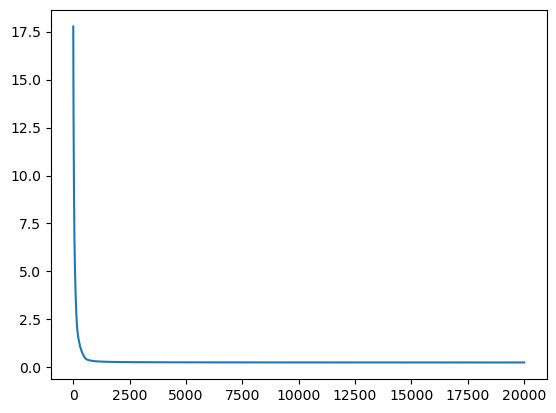

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(10000):
    # Forward pass
    emb = C[X].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y)
    losses.append(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01

plt.plot(losses)
print(loss.item())

In [ ]:
z2.max(1)

torch.return_types.max(
values=tensor([13.8922, 18.7923, 21.0705, 20.6666, 18.0411, 13.8922, 16.9343, 14.7135,
        16.7691, 19.1840, 16.6580, 21.9021, 13.8922, 18.2606, 18.1764, 19.9758,
        13.8922, 17.4331, 16.3025, 18.0223, 19.8207, 17.1016, 11.7170, 11.6275,
        16.1215, 13.8922, 17.0159, 17.7023, 13.4762, 16.6855, 20.3924, 17.6549],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

- notice that we got a very few loss, because we are overfitting small number of examples (32 examples), but even though no matter how long we train we will never reach 0 loss
    - because before the start we each word, we have the same `...` (3 dots), and for each word, the 3 dots -same input- will have different labels -starting character of the word- (so the model will never be able to get 0 loss)
        - mine: we have the same input used to predict different outputs, so the model will never be able to predict the correct output for all them
        - also there is a high chance that we have 3 characters used to predict different 4th characters

### Tips on the numerical stability of the softmax in pytorch

In [ ]:
logits = torch.tensor([-5, 0, -3, 5, 2])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.2956e-05, 6.3752e-03, 3.1740e-04, 9.4616e-01, 4.7106e-02])

- consider what happens when some of these logits take on extreme values (very large or very small), which can happen during optimization

In [ ]:
logits = torch.tensor([-100, 0, -3, 5, 2])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 6.3754e-03, 3.1741e-04, 9.4620e-01, 4.7108e-02])

- when we have very small number like -100 above, we still get probabilities that are well-behaved

In [ ]:
logits = torch.tensor([-10, 0, -3, 5, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., 0., nan])

- but when we have very large numbers like 100, we get nans, that is because the exponential of 100 is a very large number (it's infinity, simply because it coudln't be represented in flaoting point numbers), and when we divide infinity by infinity, we get nan for this number,and when we divide the rest of values whatever they are by inf, we get 0s

In [ ]:
counts

tensor([4.5400e-05, 1.0000e+00, 4.9787e-02, 1.4841e+02,        inf])

- the way pytorch solves this, is that it offsets the logits by the maximum value
- since softmax is just a normalization function, it doesn't care about the actual values of the logits, but rather the relative values of the logits to each other
    - so no matter what we add or subtract to all the logits, the probabilities will be the same

In [ ]:
logits = torch.tensor([-5, 0, -3, 5, 2]) + 6 # try changing this added value, we will still get the same probabilities
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([4.2956e-05, 6.3752e-03, 3.1740e-04, 9.4616e-01, 4.7106e-02])

- no matter what we add or subtract from the logits, the probabilities will be the same
- so we can subtract the maximum logit value from all the logits to avoid large +ve values

In [ ]:
logits = torch.tensor([-10, 0, -3, 5, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 3.7835e-44, 1.4013e-45, 5.5211e-42, 1.0000e+00])

- that is what pytorch does

## Training the model on the full dataset

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one
Y, X = [], []
for word in words:
    #print(word)
    context = ['.'] * block_size  + list(word) + ['.']
    for i in range(len(word) + 1):
        X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
        Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
        #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape

torch.Size([228146, 3])

- we now have 228146 examples (3 characters -> 1 character)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

19.505229949951172
19.139127731323242
18.824241638183594
18.554031372070312
18.31300926208496
18.091293334960938
17.884031295776367
17.68878746032715
17.504188537597656
17.329423904418945


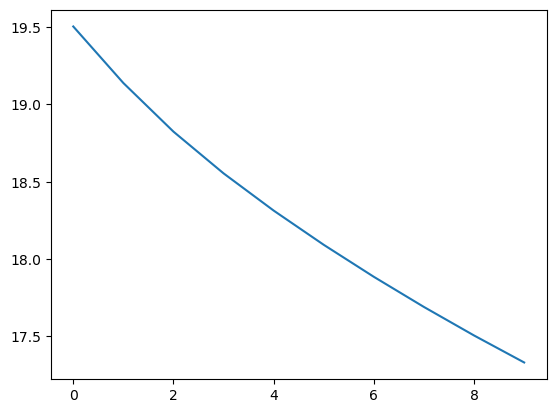

In [ ]:
for p in parameters:
    p.requires_grad = True

losses = []

for i in range(10):
    # Forward pass
    emb = C[X].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y)
    print(loss.item())
    losses.append(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01

plt.plot(losses)

- this is True GD, it takes a bit of time to train since we pass through the whole dataset before updating the parameters
- in practice, people make updates to the parameters after a small number of examples (like 32 or 64), and this is called mini-batch gradient descent
    - Sometimes this is the only way to train a model because the dataset is too large to fit in memory
- so, we want to randomly select some portion of the dataset (a mini-batch) and train on that, and then randomly select another portion of the dataset and train on that, and so on
- the `loss will decrease faster` (because we are updating the parameters after every mini-batch), `but the quality of our gradient is lower`, it's not the actual gradient direction, but it is good enough to make progress
    - `it is much better to have an approximate gradient and make more steps, than to evaluate the exact gradient and take fewer steps`

In [ ]:
batch_size = 32
torch.randint(0, X.shape[0], (batch_size,))

tensor([171250, 186024, 160711,  53791,   3105, 201446, 148491, 149499, 178649,
         25118, 122738,  19302, 131596,  69491,  73078,   5087,  74873,  12303,
         18658,  63988,  40898, 183490, 182913, 212225, 150846, 139183, 183720,
          3521,  31193,  68516, 141406,  23467])

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(10000):
    # mini-batch
    idx = torch.randint(0, X.shape[0], (batch_size,))

    # Forward pass
    emb = C[X[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.1

# calculate the final loss
emb = C[X].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, Y)
print(loss.item())

2.489607095718384


## Tip: how to determine the learning rate?
- how to get confident that we are stepping with the right speed?
    - if it is too high, the loss will oscillate (it will go up and down)
    - if it is too low, the loss will decrease too slowly (barely decreasing)
- first we decide a range of learning rates that we want to explore (say from 0.001 to 1)
    - mine: we can even run for 100 steps or so on extreme values to see the lower and upper bounds of the learning rate

- then, we can use torch.linspace to generate a range of learning rates between 0.001 and 1, but it will be linearly spaced and the problem with that is it will ignore a lot of values (check course 2 week 3)
    - but instead of stepping in the range linearly between $10^{-3}$ and $10^0$, we can step in the range logarithmically -on a log scale, which will allow us to explore wider range of learning rates-
        - and the way to implement that is to take a linear space on the exponent level -which is the log of the learning rates- (from $-3$ to $0$), so we get linearly separated exponents, then we get the actual learning rates by taking 10 to the power of that exponent
        - `that way, we are spaced exponentially -logarithmically- in the range above`


In [ ]:
lrs_exponent = torch.linspace(-3, 0, 1000)
lrs = 10**lrs_exponent
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

- so these are the candidate learning rates that we will search over (between 0.001 and 1 but exponentially stepped)
    - so, we have 1000 candidate and what we will do is to run the training loop for 1000 steps (for each learning rate candidate), and we will use a different learning rate for each step, starting from the smallest to the largest
        - we do that while keeping track of the losses for each learning rate

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

In [ ]:
for p in parameters:
    p.requires_grad = True


lossi = []
lri = []

for i in range(1000):
    # mini-batch
    idx = torch.randint(0, X.shape[0], (batch_size,))

    # Forward pass
    emb = C[X[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lrs[i]

    # track stats
    lossi.append(loss.item())
    lri.append(lrs[i])

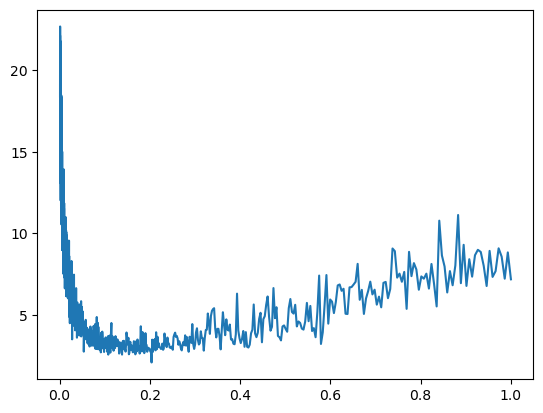

In [ ]:
plt.plot(lri, lossi)

- we often will find the plot to have the above pattern
    - at the very beginning, we had very low learning rates, so barely anything happened
    - then we get to a nice spot (at the bottom of the curve),
    - then with higher learning rates than what's right, we see that the loss starts to oscillate (it goes up and down)

- so, a good learning rate will correspond the the bottom of the curve, it is hard to find the exact learning rate, so we will track the losses against the exponents

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

In [ ]:
for p in parameters:
    p.requires_grad = True


lossi = []
lri = []

for i in range(1000):
    # mini-batch
    idx = torch.randint(0, X.shape[0], (batch_size,))

    # Forward pass
    emb = C[X[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * lrs[i]

    # track stats
    lossi.append(loss.item())
    lri.append(lrs_exponent[i])

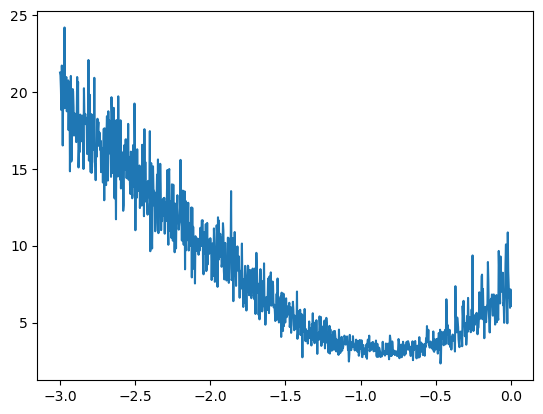

In [ ]:
plt.plot(lri, lossi)

- we see that a good learning rate exponent is around -1 (which corresponds to a learning rate of $10^{-1}$ or $0.1$), so we will use that learning rate to train the model
    - that is how we roughly determine the learning rate in advance
    - we can run for a very long time using that learning rate (mine: is it general or specific to the problem?)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(30000):
    # mini-batch
    idx = torch.randint(0, X.shape[0], (batch_size,))

    # Forward pass
    emb = C[X[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.1


# print the final loss
emb = C[X].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, Y)
print(loss.item())

2.2762491703033447


- we keep rerunning the above cell, until the loss doesn't decrease anymore
    - and now let's do learning rate decay, by taking the learning rate and 10x lower it (to $0.01$) at the late stages of training potentially to get to a better minimum

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(10000):
    # mini-batch
    idx = torch.randint(0, X.shape[0], (batch_size,))

    # Forward pass
    emb = C[X[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, Y[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01


# print the final loss
emb = C[X].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, Y)
print(loss.item())

2.225883960723877


- Recap
    - we first find a decent learning rate using the approach we saw above (using exponentially spaced learning rates in some range)
    - then we start with it and train for a while until the loss doesn't decrease anymore, now we do learning rate decay by a ceratin factor (like 10x) and train for a few

## Analyzing the results

- the model got us around 2.26 loss, which is lower than what we got with the bigram model (2.46 loss)
- but there is something to be careful with, having a lower loss doesn't always mean a better model, why?
    - this model is failry small, but sometimes the models can get larger and larger as we add more parameters (we could have thousands or millions of parameters)
    - and as the capcaity of the model grows, it becomes more and more capable of overfitting the training set (that means all the model is doing is memorizing the training set verbaitm (literally)),
    - and in the context of language modeling, if we take that model and try to sample from it, we will basically only get examples exactly as they are in the training set, and if we try to calcualte the probability of new similar examples, it will be very low
- so, `the standard in the field is to split up the dataset into 3 splits`, the training split, the validation split, and the test split
    - typically, train could be 80% of the data, validation could be 10% of the data, and test could be 10% of the data (roughly)
    - now these 80% of the dataset is used to train the model
    - and the 10% is used to tune the hyperparameters (like the learning rate, the size of the hidden layer, etc.), and by tuning we mean we try a lot of options of these hyperparameters and see which one gives us the best performance on the validation set
    - the final 10% is used to evaluate the model at the end on data that it has never been adjusted on

## Split the dataset

In [ ]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(50000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01


# print the final loss
emb = C[x_train].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.245361328125
Validation Loss: 2.24772310256958


- so we got comparable losses on the train and validation set, even though the model parameters were not optimized on the validation set, so we are not overfitting
    - the model is not powerful enough to memorize the training data, and so far we are what's called `underfitting, because the train loss and the dev loss are roughly equal` and we expect to gain perfrmance improvments by scaling up the network, mine: i guess what he means is that as long as both are equal, we can always make the model larger and the loss smaller up to a certain point before we start overfitting

- we seem to be saturating at around 2.2 loss on both the train and validation set, so we are not overfitting yet, and we expect to gain performance improvements by scaling up the network

## Experiment: Larger Hidden Layer

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn((300,), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
print(sum(p.numel() for p in parameters))

10281


- now we have around 10,000 parameters

In [ ]:
lri = []
lossi = []

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(30000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, 6)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01

    # track stats
    lossi.append(loss.item())

# print the final loss
emb = C[x_train].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, 6)
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.223780870437622
Validation Loss: 2.234570264816284


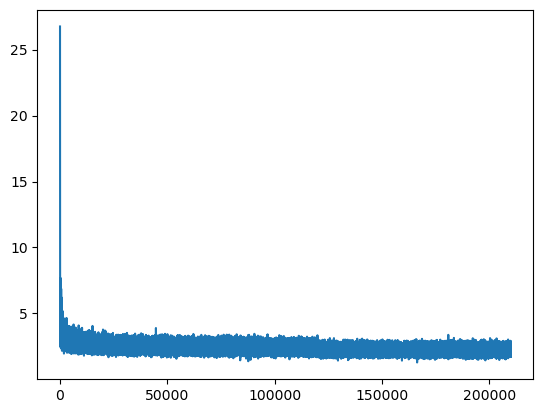

In [ ]:
plt.plot(torch.arange(len(lossi)), lossi)

- there is quite a bit of thickness in the loss curve, and that is because we are optimizing on the mini-batches, they create a little bit of noise in this
    - we may wanna increase the batch size to reduce the noise and have a higher quality gradient, that will allow us to see the trend more clearly (actually we will plot the log of the loss to see the trend more clearly next)

- we see that we still at the same loss even after increasing the hidden layer size, so it could be that the bottleneck of the network right now are the embeddings (the 2-dimensional embeddings),
    - it can be that we are cramming way too many points -characters- into a very small space, and the neural net is not able to use that space effectively

## Visualizing the Embeddings (before we scale them up)

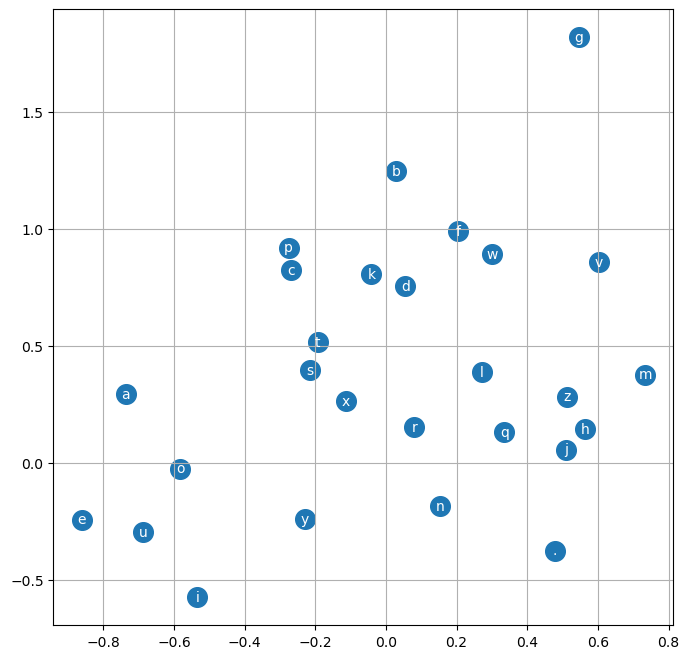

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i],ha='center', va='center',c='white')
plt.grid('minor')

- we see that the network has learned to separate out the characters and cluster them a little bit
    - see the vowels are clustered on bottom left (it means the neural net teats them in a similar way and that they appear in similar contexts in the names) `kind of like interchangable`
    - notice how the `g` is very far from the rest of the characters, and so on

## Scale up the embeddings
- we will use embeddings of size 10, and make the hidden layer smaller (200 this time)
-

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,10), generator=g)
W1 = torch.randn((block_size*10,200), generator=g)
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
print(sum(p.numel() for p in parameters))

11897


- we have 11,000 parameters now, so slightly bigger (but more because of the embeddings parameters)

In [ ]:
lri = []
lossi = []

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(30000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*10)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.01

    # track stats
    lossi.append(loss.log10().item())

# print the final loss
emb = C[x_train].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.1375691890716553
Validation Loss: 2.1796610355377197


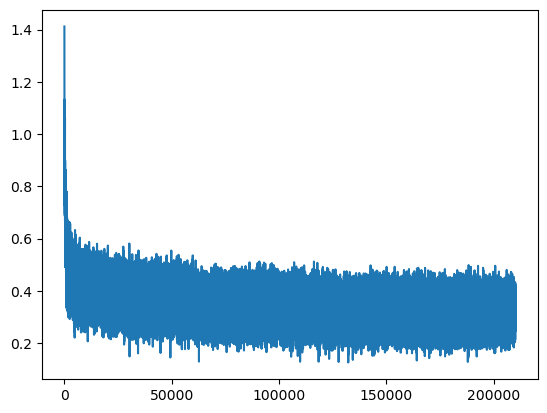

In [ ]:
plt.plot(torch.arange(len(lossi)), lossi)

- we plotted the log loss instead of the loss, as when we plot the loss iteself many times it can have a hockey stick shape (so log squashes it in)
- again, it is very thick because the mini-batch size is very small

- optimization in practice
    - in here we are optimizing at random,
    - in production, we would create hyperparameter of all of these settings, and we would draw lots of experiments, and then slowly scrutinize(meaning examine or inspect closely and thoroughly) whichever give us the best dev loss
    - once we find all the hyperparameters that make the dev performance good, we take that model and evaluate on the test set a single time, and that is the number that we report

- results
    - we see that the training and validation loss start to slightly and slowly depart, that is when we know that we are escaped underfitting and are slowly starting to overfit
    - and since we managed to lower the loss,`it was the embedding size that was the bottleneck`, and we managed to scale up the embeddings and lower the loss

Exercise: beat 2.17 loss

- what to do next
    - we can continue tuning the optimization
        - how long are we running
        - what is the learning rate
        - how does the learning rate decay (we started with 0.1 then 0.05 then 0.01 to reach 2.17 loss), so you might lower that learning rate even more and optimize that more
        - what is the batch size
    - continue playing with the size of the neural net
    - or increase the block size (the context size) to 4 or 5 tokens (characters) instead of 3



## Mine: Exercise

### Optimizing Further

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(30000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*10)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.0001

    # track stats
    lossi.append(loss.log10().item())

# print the final loss
emb = C[x_train].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.1212477684020996
Validation Loss: 2.1645641326904297


- we reached a better loss than 2.17, by further lower the learning rate

### Using larger embeddings and hidden size

In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
emb_size = 10
hidden_size = 200
C = torch.randn((27,emb_size), generator=g)
W1 = torch.randn((block_size*emb_size,hidden_size), generator=g)
b1 = torch.randn((hidden_size,), generator=g)
W2 = torch.randn((hidden_size,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
print(sum(p.numel() for p in parameters))

13897


In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(30000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*emb_size)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.0001

    # track stats
    lossi.append(loss.log10().item())

# print the final loss
emb = C[x_train].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1))
z2 = a1 @ W2 + b2
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1))
z2 = a1 @ W2 + b2
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.13608717918396
Validation Loss: 2.1847217082977295


- we can't beat 2.17 val loss, so the bottleneck is not the embeddings or the hidden size, so we can try to increase the context size

### using a larger context size (with the previous embeddings and hidden size)

In [ ]:
block_size = 4
def build_dataset(words):
    #block_size = 4 # context length: how many characters do we take to predict the next one
    Y, X = [], []
    for word in words:
        #print(word)
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]]) # append at index i, i+1, i+2 (i+3 is the label, that is why it is excluded here)
            Y.append(stoi[context[i+block_size]]) # append the character i+3 as the label
            #print(''.join(context[i:i+block_size]), '->', context[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle the words
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])

torch.Size([182544, 4]) torch.Size([182544])
torch.Size([22740, 4]) torch.Size([22740])
torch.Size([22862, 4]) torch.Size([22862])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
# parameters
C = torch.randn((27,10), generator=g)
W1 = torch.randn((block_size*10,200), generator=g)
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2] # all parameters
print(sum(p.numel() for p in parameters))

19897


In [ ]:
lossi = []

In [ ]:
for p in parameters:
    p.requires_grad = True


for i in range(5000):
    # mini-batch
    idx = torch.randint(0, x_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[x_train[idx]].view(-1, block_size*10)
    a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
    z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
    # Compute loss
    loss = F.cross_entropy(z2, y_train[idx])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= p.grad * 0.001

    # track stats
    lossi.append(loss.log10().item())

# print the final loss
emb = C[x_train].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2
loss = F.cross_entropy(z2, y_train)
print("Training Loss:", loss.item())

# validation loss
emb = C[x_val].view(-1, block_size*C.shape[1])
a1 = torch.tanh((emb @ W1 + b1)) # mX6 @ 6X100 = mX100 + 1X100 = mX100
z2 = a1 @ W2 + b2 # mX100 @ 100X27 = mX27 + 1X27 = mX27
loss = F.cross_entropy(z2, y_val)
print("Validation Loss:", loss.item())

Training Loss: 2.399984836578369
Validation Loss: 2.4054720401763916


- didn't work

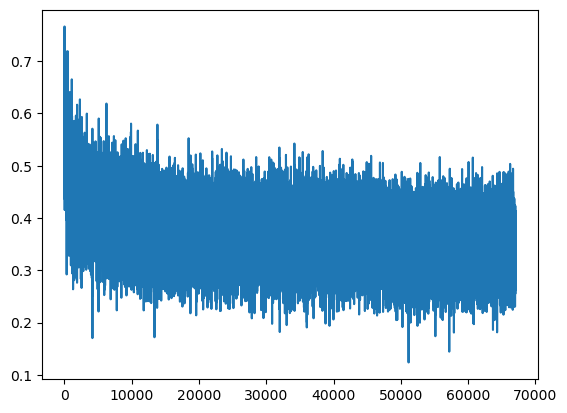

In [ ]:
plt.plot(lossi[-1000:])

## General tweakings
- apply better weight initialization (like xavier or he)

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState
import random

block_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_val_loss = float('inf')

# Assuming words and stoi are defined elsewhere

def build_dataset(words):
    Y, X = [], []
    for word in words:
        context = ['.'] * block_size  + list(word) + ['.']
        for i in range(len(word) + 1):
            X.append([stoi[ch] for ch in context[i:i+block_size]])  # Input context
            Y.append(stoi[context[i+block_size]])  # Label (next character)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])
# move to device
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

def objective(trial):
    # Hyperparameters to tune
    embed_size = trial.suggest_int('embed_size', 2, 27)
    hidden_size = trial.suggest_int('hidden_size', 100, 500)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Model parameters
    C = torch.empty((27, embed_size)).to(device)
    W1 = torch.empty((block_size * embed_size, hidden_size)).to(device)
    b1 = torch.empty((hidden_size,)).to(device)
    W2 = torch.empty((hidden_size, 27)).to(device)
    b2 = torch.empty((27,)).to(device)

    # Initialize parameters
    nn.init.uniform_(C, a=-0.1, b=0.1)
    nn.init.uniform_(W1, a=-0.1, b=0.1)
    nn.init.uniform_(b1, a=-0.1, b=0.1)
    nn.init.uniform_(W2, a=-0.1, b=0.1)
    nn.init.uniform_(b2, a=-0.1, b=0.1)

    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    # Training loop
    for i in range(60000):
        idx = torch.randint(0, x_train.shape[0], (batch_size,))

        # Forward pass
        emb = C[x_train[idx]].view(-1, block_size * embed_size)
        if activation == 'relu':
            a1 = torch.relu(emb @ W1 + b1)
        else:
            a1 = torch.tanh(emb @ W1 + b1)
        z2 = a1 @ W2 + b2
        loss = F.cross_entropy(z2, y_train[idx])

        # add regularization
        l2_reg = 1e-4 * sum(torch.sum(p ** 2) for p in parameters)
        loss += l2_reg

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update parameters
        for p in parameters:
            p.data -= p.grad * learning_rate

    # Validation loss
    with torch.no_grad():
        emb = C[x_val].view(-1, block_size * embed_size)
        if activation == 'relu':
            a1 = torch.relu(emb @ W1 + b1)
        else:
            a1 = torch.tanh(emb @ W1 + b1)
        z2 = a1 @ W2 + b2
        val_loss = F.cross_entropy(z2, y_val).item()
    # save the best model
    global best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(parameters, 'best_model.pt')

    return val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

In [116]:
print("Best trial:")
trial = study.best_trial

print(f"Loss: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Best trial:
Loss: 2.089946746826172
Params: 
embed_size: 19
hidden_size: 383
batch_size: 64
activation: relu
learning_rate: 0.039755695170916476


## Sample from the model

In [117]:
parameters = torch.load('best_model.pt')
C = parameters[0].to(device)
W1 = parameters[1].to(device)
b1 = parameters[2].to(device)
W2 = parameters[3].to(device)
b2 = parameters[4].to(device)

In [119]:
with torch.no_grad():
    emb = C[x_train].view(-1, block_size * 19)
    a1 = torch.relu(emb @ W1 + b1)
    z2 = a1 @ W2 + b2
    train_loss = F.cross_entropy(z2, y_train.to(device)).item()
    print(train_loss)

2.038970947265625


In [120]:
context = [0] * block_size
C[torch.tensor(context)].view(1, -1).shape

torch.Size([1, 76])

In [126]:
g = torch.Generator(device=device).manual_seed(2147483647 + 4)

for _ in range(20):
    out = []
    context = [0] * block_size # we start with the '.' index, block_size times
    while True:
        emb = C[torch.tensor(context)].view(1,-1) # 1Xblock_size -> 1Xblock_sizeXemb_dim
        a1 = torch.tanh((emb @ W1 + b1))
        z2 = a1 @ W2 + b2
        probs = F.softmax(z2, dim=1)
        next_char_idx = torch.multinomial(probs.view(-1), 1).item()
        context = context[1:] + [next_char_idx] # shift the context by one
        out.append(next_char_idx)
        if next_char_idx == 0:
            break

    # print the example now
    print(''.join([itos[i] for i in out]))

hana.
jabrettony.
kallyn.
favin.
modf.
chel.
masten.
shan.
mullin.
brwen.
azabrin.
kadzo.
hellez.
kanzel.
bwil.
hand.
bromelyan.
mile.
soud.
malanne.


## mine: Takeaways

1. `Think about the minimum global loss we might achieve`, sometimes it is impossible to achieve 0 loss even on a single batch. In other words, it is not the global minimum, because of the nature of the problem (like the 3 dots at the beginning of each word used to predict different first characters)
2. `Mini-batch gradient descent`, it is the standard in practice
    - instead of True GD, which makes a forward and backward pass on the whole dataset in order to make a single update to the parameters, we use mini-batch gradient descent, which takes random small portions of the dataset (mini-batches) and makes updates to the parameters after each mini-batch
    - it is faster since we update the parameters after few examples, but the quality of the gradient is lower (it is not the actual gradient direction, but it is good enough to make progress)
        - `it is much better to have an approximate gradient and make more steps, than to evaluate the exact gradient and take fewer steps`
    - sometimes it is the only way to train a model because the dataset is too large to fit in memory at once
    - if you used mini-batches and plotted the loss, it will have large thickness of noise -but don't confuse it with the oscillations-, because of using mini-batches (so it is important to only care about the trend)
        - sometimes we take the log of the loss to see the trend more clearly or increase the batch size to reduce the noise and have a higher quality gradient

3. `Train/Validation/Test split`, it is the standard in the field
    - why do we split?
        - as the model gets better and better (larger and more complex), the loss gets smaller and smaller
        - but smaller loss means better performance **up to a certain point**, after which the model starts to memorize the training set (overfitting)
        - and if the model memorized the training set, it will not be able to generalize to new examples (in the context of language modeling, if we sample from it, it will only give us examples exactly as they are in the training set, and if we try to calcualte the probability of new similar examples, it will be very low)
        - so we need another set of data that the model has never seen `validation set`, to ensure that lower loss is actually better performance and not just memorizing the training set
            - by making sure it is the same loss on the training and validation set

4. `Hyperparameter tuning`, hyperparameters are the design choices that we make up to us (like the learning rate, the size of the hidden layer, the optimizer, the batch size, etc.)
    - to ensure that we selected the best hyperparameters, we do the above step (optimizing on the training set and making sure lower loss is actually better performance on the validation set) for different hyperparameter choices, then we see which one gives us the best performance on the validation set
        - there are a lot of methods on how to do that, like grid search, random search, bayesian optimization, etc.
        - like in the above code i used optuna to do the hyperparameter tuning (it is a bayesian optimization library)
    - then we take that model and evaluate on the test set a single time, and that is the number that we report, because we never adjusted the model or the hyperparameters on the test set
    - 
    

5. `optimization in the industry` in here we are optimizing at random,
    - in production, we would create hyperparameter of all of these settings, and we would draw lots of experiments, and then slowly scrutinize (meaning examine or inspect closely and thoroughly) whichever give us the best dev loss
    - once we find all the hyperparameters that make the dev performance good, we take that model and evaluate on the test set a single time, and that is the number that we report
    - CHATgpt: hyperparameter tuning in deep learning often requires special strategies to balance the computational cost with the need for performance improvements. Here are some practical approaches used in deep learning:
        -  Smaller Subset of Data: One technique is to use a smaller subset of the data for hyperparameter tuning. This allows for faster iterations during tuning, although care must be taken to ensure that the smaller set is representative of the full dataset.

        - Transfer Learning: Pre-trained models (e.g., models pre-trained on ImageNet) are often fine-tuned on specific tasks. This reduces training time and allows for effective hyperparameter tuning by focusing only on the fine-tuning stage.

        - Automated Hyperparameter Optimization: Tools like Hyperopt, Optuna, or Ray Tune offer more efficient search algorithms, such as Bayesian optimization and Tree-structured Parzen Estimators (TPE), which can help narrow down good hyperparameter values with fewer trials.

        - Asynchronous Successive Halving Algorithm (ASHA): ASHA prunes poorly performing trials early in the training process, which saves time and resources by focusing only on promising configurations.

        - Population-based Training (PBT): PBT is a more advanced technique where multiple model copies are trained in parallel with different hyperparameter configurations. The less promising models can adopt the parameters of better-performing models, and the hyperparameters are tuned as training progresses.

        - Learning Rate Schedulers and Optimizers: Instead of static learning rates, techniques like learning rate annealing, cyclical learning rates, or adaptive optimizers (like Adam or AdamW) can help improve training stability and performance without requiring exhaustive manual tuning.

6. `learning rate`, how to roughly determine the starting learning rate? (mine: I think that will be done if we will babysit a model -unlike the above approach-)
    - first we decide a range of learning rates that we want to explore (say from 0.001 ($10^{-3}$) to 1 ($10^0$))
    - we sample from that range some number of learning rate candidates (say 1000)
        - we do that on the log scale, so that we can explore wider range of learning rates
        - so the $log_{10}(10^{-3})$ is -3 and the $log_{10}(10^0)$ is 0, so we take a linear space from -3 to 0 (on the exponent level), then we get the actual learning rates by taking 10 to the power of that exponent
        ```python
        learning_rate_exponents = torch.linspace(-3, 0, 1000)
        learning_rates = 10 ** learning_rate_exponents
        ```
    - now we have 1000 exponentially spaced learning rates in the range above, we run for 1000 steps (for each learning rate candidate), and we update using each learning rate candidate starting from the smallest to the largest, and we keep track of the losses for each learning rate
    - then we plot the losses against the learning rates (or much better the exponents to see the trend more clearly), and we see that it will start high loss and then decrease slowly because of the small learning rate candidates at the beginning, then it will reach a nice spot (at the bottom of the curve), then with higher learning rates than what's right, the loss starts to oscillate (it goes up and down)
    - we simply choose the learning rate exponent that corresponds to the bottom of the curve, and the learning rate will be $10^{exponent}$ and this is the learning rate that we will use to train the model
    - as we train, we will get to a point where the loss doesn't decrease anymore and kind of saturates or oscillates around a certain value, that is when we do learning rate decay, by taking the learning rate and lower it by a certain factor (like 10x) and train for a few more steps until the loss doesn't decrease anymore
    - `tip: The process applies just the same with Adam and other optimizers`
        - Andrej experience is that Adam is much more robust though. So a good learning rate in the case of SGD is very much problem and initialization -dependent and very narrow, while a good learning rate in the case of Adam is less problem-dependent and more forgiving. E.g. learning rate 3e-4 for Adam may not be optimal for all problems, but is almost always a pretty good baseline. You can't make a statement like that for SGD

7. `mine: Performance concepts`
    - we said that the job of the `validation set` is to ensure that lower loss means better performance -and not memorization- by making sure that the loss is the same on the training and validation set
        - and we do that until the loss starts to slightly and slowly depart (becomes better on the training than the validation), which means that the model is starting to overfit (it is memorizing the training set)
            - and as long as it has never reached that point yet, (meaning that the loss is the same on the training and validation set and it can't get lower), we are said to be underfitting (the model is not powerful enough)
            - and we expect to gain performance improvements by scaling up the network (we keep scaling up and lowering both losses until they start to depart)
                -  we should be smart too about scaling up, we should think about what is the bottleneck of the network right now, and scale up that part (just like we scaled the hidden layer size then we saw it didn't work, then we scaled up the embeddings and it turned out to be the bottleneck)
                - so we keep scaling up the bottlenecks and see the next potential bottleneck and scale it up, and so on until the model becomes too powerful to the data
    - i noticed the following 
        - lower validation loss with higher gap between the training and validation loss generated worse results than little higher validation loss with lower gap between the training and validation loss
            - like training loss of 1.9 and validation loss 2.03 (gap is 0.13) did wrose than training loss 2.03 and validation loss 2.07 (gap is 0.04)
        - i searched about it and i found the following 
            - Local optima vs. global behavior:
                - A model with higher loss might have learned some useful global patterns or structures, even if it's not as good at predicting specific characters.
                - Conversely, a model with lower loss might have overfitted to local patterns without capturing broader linguistic structures.
        - that is why i used regularization above (led to slighly higher validation loss, and lower gap between the training and validation loss, but generated better results)
        - maybe an explanation for this phenomenon is that binary cross entropy loss is not really the best metric to evaluate these models



